# Создание DataFrame с квадратурно-амплитудными символами модуляции

## Загрузим библеотеку ModulationPy и CommPy

In [ ]:
! pip install ModulationPy
! pip install scikit-commpy

#### Создадим DataFrame, который будет хранить в себе параметры
- Уровень модуляции M (4, 16, 64, 256, 1024) [5 вариантов];
- Отношение сигнал шум (от 50 до 0 с шагом 2) [26 вариантов];
- Фазовый сдвиг в градусах (от 0 до 90 с шагом 3) [31 вариантов];

Так как с каждой страты `5*26*31=4030 страт` мы будем извлекать 3 последовательности QAM символов длиной = 4096 символов, то в итоге мы получим 12090 последовательностей QAM символов с разными параметрами

In [2]:
# Подключение необходимых модулей, для создания и визуализации датасета 
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ModulationPy as mpy
from commpy.channels import awgn

### Проверим нормальность распределения последовательности бит и последовательности чисео от 0 до M-1

Для это создадим два модулятора с разными параметрами

In [3]:
M = 256
N = 1024
bin_modulator = mpy.QAMModem(M, bin_input=True)
symbols_modulator = mpy.QAMModem(M, bin_input=False)

И две последовательности: битовую и числовую

In [4]:
bin_consq = np.random.randint(2, size=int(N*np.log2(M)))
symbols_consq = np.random.randint(M, size=N)
bin_consq, symbols_consq

(array([0, 1, 0, ..., 0, 1, 0]), array([  2,  58, 179, ..., 150, 201,  38]))

Преобразуем битовую последовательность в числовую последовательность от 0 до M-1

In [5]:
bin_symb_consq = np.resize(bin_consq, (N, int(np.log2(M))))
# Функция для преобразования последовательности бит в число
def bool2int(x):
    y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y
bin_symb_consq = np.array([bool2int(x[:]) for x in bin_symb_consq])
bin_symb_consq, max(bin_symb_consq)

(array([178,  86, 101, ...,  87, 127,  89]), 255)

Построим гистограмму распределения

Text(0.5, 1.0, 'Гистограмма распр-ия от числовой посл-ти')

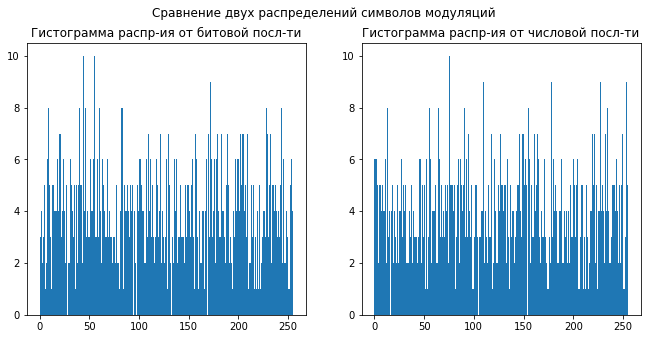

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Сравнение двух распределений символов модуляций')
fig.set_size_inches(11, 5)
ax1.hist(bin_symb_consq, bins=M);
ax1.set_title('Гистограмма распр-ия от битовой посл-ти')
ax2.hist(symbols_consq, bins=M);
ax2.set_title('Гистограмма распр-ия от числовой посл-ти')

Построим диаграмму созвездия для данных последовательностей

In [7]:
# Модуляция
bin_QAM = bin_modulator.modulate(bin_consq)
symbols_QAM = symbols_modulator.modulate(symbols_consq)
# Нормировка
bin_QAM = bin_QAM/max(abs(bin_QAM))
symbols_QAM = symbols_QAM/max(abs(symbols_QAM))

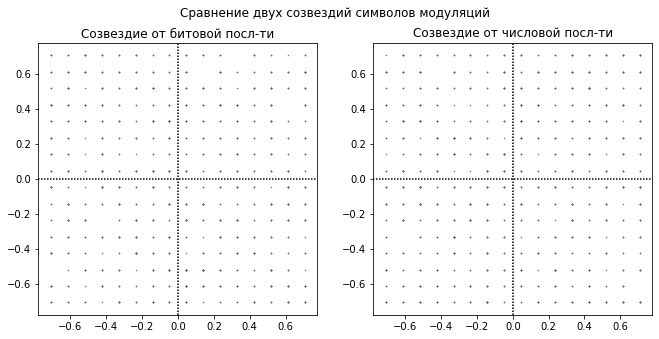

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Сравнение двух созвездий символов модуляций')
fig.set_size_inches(11, 5)

ax1.scatter(bin_QAM.imag, 
            bin_QAM.real,
            marker='.',
            s=1)

ax1.axhline(0, c='black', dashes=(1, 1))
ax1.axvline(0, c='black', dashes=(1, 1))

ax1.set_title('Созвездие от битовой посл-ти')

ax2.scatter(symbols_QAM.imag, 
            symbols_QAM.real,
            marker='.',
            s=1)

ax2.set_title('Созвездие от числовой посл-ти')

ax2.axhline(0, c='black', dashes=(1, 1))
ax2.axvline(0, c='black', dashes=(1, 1))

## Создадим DataFrame, который будет хранить в себе параметры

- Уровень модуляции M (4, 16, 64, 256, 1024) [5 вариантов];
- Отношение сигнал шум (от 50 до 0 с шагом 2) [26 вариантов];
- Фазовый сдвиг в градусах (от 0 до 90 с шагом 3) [31 вариантов];

Так как с каждой страты `5*26*31=4030 страт` мы будем извлекать 3 последовательности QAM символов длиной = 4096 символов, то в итоге мы получим 12090 последовательностей QAM символов с разными параметрами


-------------------------------------------------------------

In [33]:
# Создаем объект DataFrame с колонками: M, SNR, Phase_shift, QAM_symbols
QAM_symbols_df = pd.DataFrame({'M':[1],
                               'SNR':[1],
                               'Phase_shift':[1],
                               'QAM_symbols':[np.array([1+1j, 
                                                        1+1j, 
                                                        1+1j, 
                                                        1+1j])]}) 
from tqdm.notebook import tqdm # Установка прогресс бара

N = 4096
for M in tqdm([4, 16, 64, 256, 1024]): # Перебор уровней модуляции
  # Объявляем модулятор
  modulator = mpy.QAMModem(M, bin_input=False)
  for SNR in range(50, -2, -2): # Перебор отношения сигнал\шум
    for sh in range(0, 93, 3): # Перебор фазовых сдвигов
      for _ in range(3): # Выбираем 3 последовательности из страты
        consq = np.random.randint(M, size=N) # Создаем последовательность 
        QAM_symbols = modulator.modulate(consq) # Процесс модуляции
        QAM_symbols = awgn(QAM_symbols, SNR)
        phase_shift = sh*np.pi/180 # Перевод градус в радианы
        QAM_symbols = QAM_symbols/max(abs(QAM_symbols)) # Нормировка
        QAM_symbols = QAM_symbols*np.exp(phase_shift*1j) # Добавление фазового сдвига
        # Добавляем параметры в таблицу
        QAM_symbols_df.loc[len(QAM_symbols_df.index)] = [int(M), 
                                                         SNR, 
                                                         sh, 
                                                         QAM_symbols]
print("Завершенно!")


Завершенно!


In [34]:
QAM_symbols_df = QAM_symbols_df.drop(index=0) # Удаляем первую добавочную строку

In [35]:
QAM_symbols_df

,M,SNR,Phase_shift,QAM_symbols
1,4,50,0,"[(-0.7036042890718478-0.7015965700383437j), (-..."
2,4,50,0,"[(0.7000176983831482+0.7017988294499098j), (-0..."
3,4,50,0,"[(-0.7012399175816748+0.7006997663287179j), (-..."
4,4,50,3,"[(-0.7373106306501424+0.6599227864856388j), (-..."
5,4,50,3,"[(-0.6654392596175167-0.738886801992581j), (-0..."
...,...,...,...,...
12086,1024,0,87,"[(-0.31081193074978336-0.303232417118603j), (-..."
12087,1024,0,87,"[(0.22578773868494298-0.15757383658954258j), (..."
12088,1024,0,90,"[(0.19868073334004457+0.2022611921770635j), (0..."
12089,1024,0,90,"[(0.018172504916361402-0.051394528036286705j),..."


In [53]:
test = QAM_symbols_df[(QAM_symbols_df.M == 64) & 
                      (QAM_symbols_df.SNR == 30) & 
                      (QAM_symbols_df.Phase_shift == 30)] \
                      .iloc[0].QAM_symbols

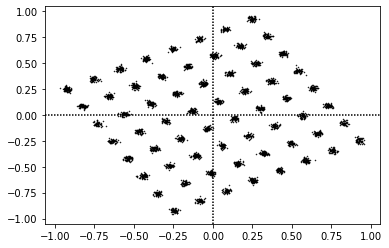

In [57]:
plt.scatter(test.real, 
            test.imag,
            c='black',
            marker='.',
            s=1)

# plt.scatter(qam_signals_df.apply(abs), 
#             qam_signals_df.apply(abs),
#             c='blue',
#             marker='*',
#             s=20)

plt.axhline(0, c='black', dashes=(1, 1))
plt.axvline(0, c='black', dashes=(1, 1))

In [59]:
from google.colab import files
QAM_symbols_df.to_csv('QAM_symbols_df.csv')
files.download('QAM_symbols_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>